# Notebook 3: Analysis of Experimental Results

### Goal
This notebook is for analyzing the outputs of our experiments. We will load the saved model checkpoints and results files from the `outputs/` directory to generate the key tables and figures for the thesis.

### Steps
1.  **Load Results:** Load the `.csv` files containing the performance metrics for all experimental runs (e.g., our GNN-NCM, a baseline GCN).
2.  **Overall Performance Comparison:** Create a table comparing the overall predictive accuracy (e.g., RMSE, MAE) of all models on the full test set.
3.  **Robustness Under Intervention (The Key Figure):**
    *   Define "stable" and "shock" periods based on our list of historical events.
    *   Calculate the performance of each model separately for these two periods.
    *   Create a bar chart showing the **performance degradation** (e.g., percentage increase in RMSE) for each model during the shock period. This is the primary evidence for our thesis statement.
4.  **Case Study: A Single Intervention:**
    *   Load our trained `GNN-NCM`.
    *   Select a significant historical event (e.g., a major interest rate hike).
    *   Perform a `do_intervention` on the corresponding macro node.
    *   Analyze and interpret the predicted downstream effects on different sectors, comparing them to economic theory.
5.  **Conclusion:** Summarize the findings and articulate the final conclusions for the thesis.

In [2]:
# lightweight, minimal imports
import os, json, yaml, glob, math, random, time, sys
import torch, torch.nn as nn, torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset

PROJECT_ROOT = Path().resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))  
    
DATA_DIR = PROJECT_ROOT / "data" / "processed"
CONFIGS_DIR = PROJECT_ROOT / "configs"
OUTPUTS_DIR = PROJECT_ROOT / "outputs"

# local project imports
from src.models import GNN_NCM, BaselineGCN, TeacherGNN
from src.dataloader import CausalFactorDataset
from src.trainer import HybridCausalTrainer  

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["axes.grid"] = True

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_DIR:", DATA_DIR)
print("OUTPUTS_DIR:", OUTPUTS_DIR)


PROJECT_ROOT: C:\Users\asus\OneDrive\Desktop\thesis
DATA_DIR: C:\Users\asus\OneDrive\Desktop\thesis\data\processed
OUTPUTS_DIR: C:\Users\asus\OneDrive\Desktop\thesis\outputs


### Load Best Parameters

In [3]:
# try to load best config; fallback to defaults
cfg_path = CONFIGS_DIR / "best_config.yaml"
if cfg_path.exists():
    with open(cfg_path, "r") as f:
        cfg = yaml.safe_load(f)
else:
    cfg = {
        "experiment_name": "GNN_NCM_Tuned_Run",
        "seed": 42,
        "device": "cuda" if torch.cuda.is_available() else "cpu",
        "data": {
            "data_dir": str(DATA_DIR),
            "target_nodes": ["VOL"],
        },
        "model": {
            "name": "GNN_NCM",
            "gnn_mode": "per_edge",
            "hidden_dim": 32,
            "out_dim": 16,
            "noise_dim": 4,
        },
        "training": {
            "type": "HybridCausalTrainer",
            "epochs": 50,
            "lr": 0.01,
            "gamma": 0.5,
            "batch_size": 1,
        },
        "output": { "output_dir": str(OUTPUTS_DIR) }
    }

cfg_device = cfg.get("device", "cuda" if torch.cuda.is_available() else "cpu")
device = torch.device(cfg_device if torch.cuda.is_available() or "cpu" in cfg_device else "cpu")
print("Device:", device)


Device: cuda


### Datasets

In [4]:
# dataset
ds = CausalFactorDataset(
    root_dir=str(DATA_DIR),
    target_node="VOL",
    feature_col=None,              # auto-detect the single numeric column
    drop_self_for_target=True,     # avoid leakage
)

# train/val split
split = int(0.8 * len(ds))
idx_train = list(range(split))
idx_val   = list(range(split, len(ds)))

train_loader = DataLoader(Subset(ds, idx_train), batch_size=cfg["training"].get("batch_size", 1), shuffle=True)
val_loader   = DataLoader(Subset(ds, idx_val),   batch_size=1, shuffle=False)

# dims
g0 = next(iter(train_loader))
num_features = g0.num_node_features
num_edges = g0.edge_index.size(1)

print("num_features:", num_features, "| num_edges:", num_edges, "| num_nodes:", g0.num_nodes)
print("dates: train =", len(idx_train), ", val =", len(idx_val))


num_features: 1 | num_edges: 8 | num_nodes: 7
dates: train = 183 , val = 46


C:\Users\asus\OneDrive\Desktop\thesis\src\dataloader.py:43: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:281.)
  self.edge_index = torch.tensor([es, ed], dtype=torch.long)


## Initializing the Model and Training (if not loaded)

In [5]:
model_params = cfg["model"]
model = GNN_NCM(
    num_features=num_features,
    num_edges=num_edges,
    gnn_mode=model_params.get("gnn_mode", "per_edge"),
    hidden_dim=model_params.get("hidden_dim", 32),
    out_dim=model_params.get("out_dim", 16),
    noise_dim=model_params.get("noise_dim", 4),
).to(device)

# optional baseline for comparison later
# baseline = BaselineGCN(num_features=num_features,
#                        hidden_dim=model_params.get("hidden_dim", 32),
#                        out_dim=model_params.get("out_dim", 16)).to(device)


In [ ]:
class HybridCausalTrainerLogged(HybridCausalTrainer):
    def __init__(self, epochs=200, lr=0.01, gamma=0.5):
        super().__init__(epochs, lr, gamma)
        self.history = []
        self._val_loader = None

    def set_validation_loader(self, val_loader):
        self._val_loader = val_loader

    def train(self, model_to_train, data_or_loader):
        # duck-typing: any iterable without .x is treated as loader
        is_loader = hasattr(data_or_loader, "__iter__") and not hasattr(data_or_loader, "x")
        if is_loader: return self._train_over_loader(model_to_train, data_or_loader)
        return self._train_on_graph(model_to_train, data_or_loader)

    @torch.no_grad()
    def _val_mse_epoch(self, model):
        if self._val_loader is None: return None
        loss = nn.MSELoss(); tot=0.0; n=0
        for g in self._val_loader:
            g = g.to(next(model.parameters()).device)
            p = model(g.x, g.edge_index)
            tot += loss(p, g.y).item(); n += 1
        return tot/max(n,1)

    def _log_row(self, ep, obs, cau, tot, val):
        self.history.append({
            "epoch": int(ep),
            "loss_obs": float(obs),
            "loss_causal": float(cau),
            "loss_total": float(tot),
            "val_mse": None if val is None else float(val)
        })

    # single-graph path (unchanged except logging)
    def _train_on_graph(self, model_to_train, g):
        device = g.x.device
        model_to_train = model_to_train.to(device)
        opt = torch.optim.Adam(model_to_train.parameters(), lr=self.lr)

        teacher = TeacherGNN(g.x.size(-1), 16, 8).to(device)
        opt_t = torch.optim.Adam(teacher.parameters(), lr=0.01)
        for _ in range(100):
            opt_t.zero_grad()
            lt = F.mse_loss(teacher(g.x, g.edge_index), g.y)
            lt.backward(); opt_t.step()
        teacher.eval()

        src, dst = g.edge_index[0], g.edge_index[1]
        for ep in range(1, self.epochs+1):
            model_to_train.train(); opt.zero_grad()
            preds = model_to_train(g.x, g.edge_index)
            loss_obs = self.loss_fn(preds, g.y)

            with torch.no_grad(): tpreds = teacher(g.x, g.edge_index)

            loss_causal = 0.0; cnt = 0
            for v in range(g.num_nodes):
                parents = src[dst == v]
                if parents.numel()==0: continue
                cnt += 1
                ivals=[]
                for p in parents.tolist():
                    after = model_to_train.do_intervention(
                        g.x, g.edge_index,
                        intervened_nodes=torch.tensor([p], device=device),
                        new_feature_values=g.x.new_zeros(1, g.x.size(-1))
                    )
                    ivals.append(after[v])
                loss_causal += self.loss_fn(torch.stack(ivals).mean(0), tpreds[v])
            if cnt>0: loss_causal /= cnt

            total = loss_obs + self.gamma*loss_causal
            total.backward(); opt.step()

            self._log_row(ep, loss_obs.item(), loss_causal.item(), total.item(), self._val_mse_epoch(model_to_train))
        return model_to_train

    # loader path (works for PyG DataLoader)
    def _train_over_loader(self, model_to_train, loader):
        it = iter(loader)
        try:
            first = next(it)
        except StopIteration:
            raise ValueError("Training loader is empty.")
        device = first.x.device
        model_to_train = model_to_train.to(device)
        opt = torch.optim.Adam(model_to_train.parameters(), lr=self.lr)

        teacher = TeacherGNN(first.x.size(-1), 16, 8).to(device)
        opt_t = torch.optim.Adam(teacher.parameters(), lr=0.01)
        for _ in range(100):
            opt_t.zero_grad()
            lt = F.mse_loss(teacher(first.x, first.edge_index), first.y)
            lt.backward(); opt_t.step()
        teacher.eval()

        for ep in range(1, self.epochs+1):
            obs_sum=0.0; cau_sum=0.0; steps=0
            for g in loader:
                g = g.to(device)
                model_to_train.train(); opt.zero_grad()
                preds = model_to_train(g.x, g.edge_index)
                loss_obs = self.loss_fn(preds, g.y)
                with torch.no_grad(): tpreds = teacher(g.x, g.edge_index)

                src, dst = g.edge_index[0], g.edge_index[1]
                loss_causal=0.0; cnt=0
                for v in range(g.num_nodes):
                    parents = src[dst==v]
                    if parents.numel()==0: continue
                    cnt += 1
                    ivals=[]
                    for p in parents.tolist():
                        after = model_to_train.do_intervention(
                            g.x, g.edge_index,
                            intervened_nodes=torch.tensor([p], device=device),
                            new_feature_values=g.x.new_zeros(1, g.x.size(-1))
                        )
                        ivals.append(after[v])
                    loss_causal += self.loss_fn(torch.stack(ivals).mean(0), tpreds[v])
                if cnt>0: loss_causal /= cnt

                total = loss_obs + self.gamma*loss_causal
                total.backward(); opt.step()

                obs_sum += loss_obs.item(); cau_sum += loss_causal.item(); steps += 1

            tr_obs = obs_sum/max(steps,1)
            tr_cau = cau_sum/max(steps,1)
            tr_tot = tr_obs + self.gamma*tr_cau
            self._log_row(ep, tr_obs, tr_cau, tr_tot, self._val_mse_epoch(model_to_train))
        return model_to_train

In [7]:
# train-or-load
ckpt_path = OUTPUTS_DIR / "best_model.pt"

if ckpt_path.exists():
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.eval()
    print("Loaded checkpoint:", ckpt_path)
    # no training curve when loading; you can skip plotting if desired
    tlog_history = None
else:
    tr_cfg = cfg["training"]
    trainer = HybridCausalTrainerLogged(
        epochs=tr_cfg.get("epochs", 50),
        lr=tr_cfg.get("lr", 0.01),
        gamma=tr_cfg.get("gamma", 0.5),
    )
    trainer.set_validation_loader(val_loader)
    trainer.train(model, train_loader)

    torch.save(model.state_dict(), ckpt_path)
    print("Saved checkpoint:", ckpt_path)

    # persist training curve for reproducibility
    tlog_history = pd.DataFrame(trainer.history)
    tlog_history.to_csv(OUTPUTS_DIR / "training_curve.csv", index=False)


Saved checkpoint: C:\Users\asus\OneDrive\Desktop\thesis\outputs\best_model.pt


### Training Curves

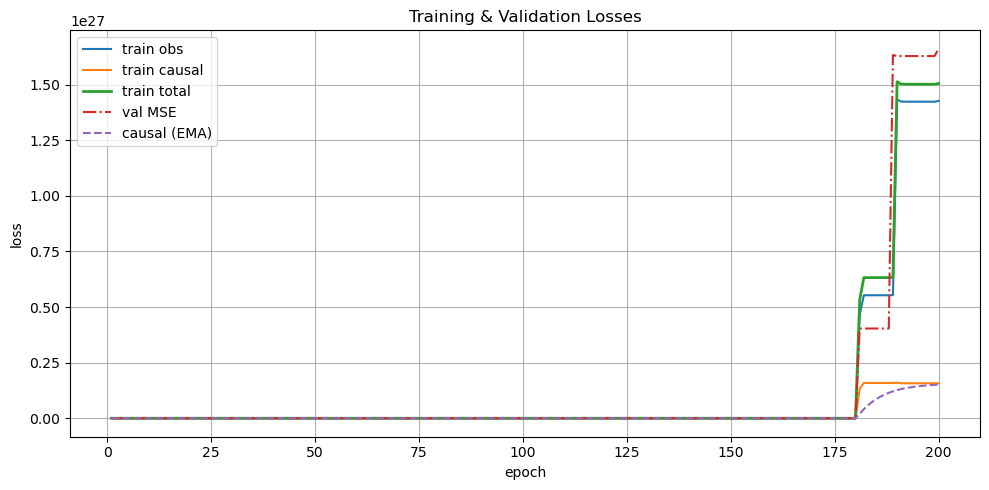

In [8]:
if tlog_history is None:
    # try to load if we just loaded a checkpoint
    curve_path = OUTPUTS_DIR / "training_curve.csv"
    if curve_path.exists():
        tlog_history = pd.read_csv(curve_path)

if tlog_history is not None and len(tlog_history) > 0:
    df = tlog_history.copy()

    def ema(x, alpha=0.15):
        y = []; s = None
        for v in x:
            s = v if s is None else alpha*v + (1-alpha)*s
            y.append(s)
        return y

    plt.figure(figsize=(10,5))
    plt.plot(df["epoch"], df["loss_obs"],    label="train obs")
    plt.plot(df["epoch"], df["loss_causal"], label="train causal")
    plt.plot(df["epoch"], df["loss_total"],  label="train total", linewidth=2)
    if "val_mse" in df and not df["val_mse"].isna().all():
        plt.plot(df["epoch"], df["val_mse"], label="val MSE", linestyle='-.')
    plt.plot(df["epoch"], ema(df["loss_causal"]), linestyle='--', label="causal (EMA)")
    plt.xlabel("epoch"); plt.ylabel("loss")
    plt.title("Training & Validation Losses")
    plt.legend(); plt.tight_layout(); plt.show()
else:
    print("No training curve to plot.")


## Overall Performance

We compute MSE on the validation set. If you want to focus on VOL only, we use its index.

In [9]:
@torch.no_grad()
def mse_on_loader(model, loader, node_idx=None):
    model.eval()
    loss = nn.MSELoss()
    tot, n = 0.0, 0
    for g in loader:
        g = g.to(next(model.parameters()).device)
        p = model(g.x, g.edge_index)
        if node_idx is None:
            tot += loss(p, g.y).item()
        else:
            tot += loss(p[node_idx], g.y[node_idx]).item()
        n += 1
    return tot / max(n,1)

vol_idx = ds.node_map["VOL"]
val_mse_full = mse_on_loader(model, val_loader, node_idx=None)
val_mse_vol  = mse_on_loader(model, val_loader, node_idx=vol_idx)

perf_df = pd.DataFrame([
    {"metric": "Val MSE (all nodes)", "value": val_mse_full},
    {"metric": "Val MSE (VOL only)",  "value": val_mse_vol},
]).set_index("metric")
display(perf_df)


,value
metric,
Val MSE (all nodes),1.660761e+27
Val MSE (VOL only),8.685499e+27


### Robustness Under Shock (Observational Shock)

We compare validation MSE with and without a shock to a chosen node (e.g., BAS × 5). This is not a do-operation; it’s an OOD stress test.

,MSE (Normal),MSE (Shock)
Shock BAS ×5,1.660761e+27,1.660768e+27


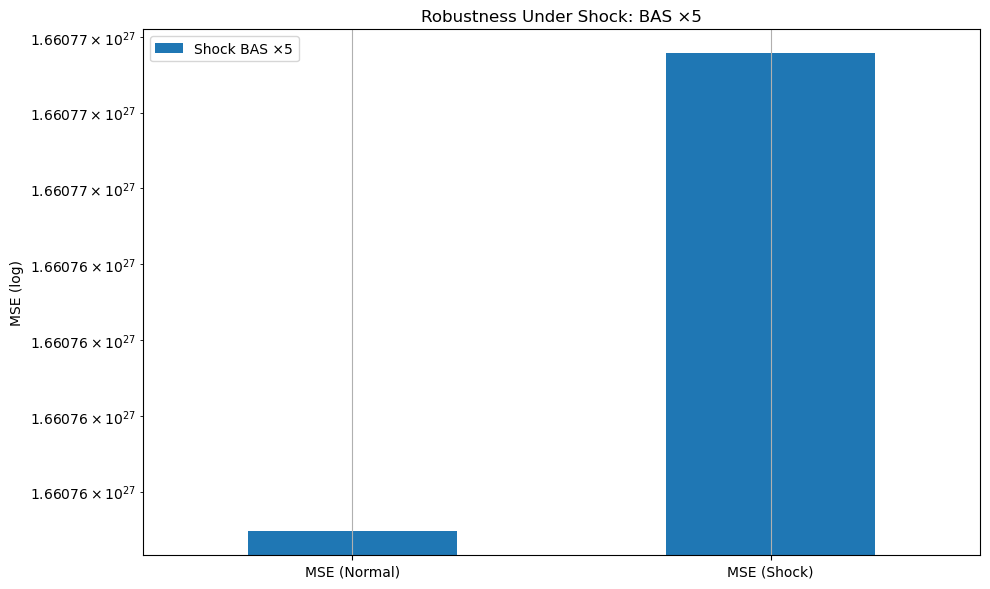

In [10]:
@torch.no_grad()
def robustness_mse(model, dataset, node_idx, factor=5.0, indices=None):
    model.eval()
    loss = nn.MSELoss()
    tot_n, tot_s, n = 0.0, 0.0, 0
    idxs = indices if indices is not None else range(len(dataset))
    for i in idxs:
        g = dataset[i]
        g = g.to(next(model.parameters()).device)
        p_n = model(g.x, g.edge_index)

        x_s = g.x.clone()
        x_s[node_idx] = x_s[node_idx] * factor
        p_s = model(x_s, g.edge_index)

        tot_n += loss(p_n, g.y).item()
        tot_s += loss(p_s, g.y).item()
        n += 1
    return (tot_n / max(n,1), tot_s / max(n,1))

# choose node to shock (BAS if present; else pick any)
shock_node = "BAS" if "BAS" in ds.node_map else list(ds.node_map.keys())[0]
shock_idx = ds.node_map[shock_node]
mse_n, mse_s = robustness_mse(model, ds, node_idx=shock_idx, factor=5.0, indices=idx_val)

rob_df = pd.DataFrame([{"MSE (Normal)": mse_n, "MSE (Shock)": mse_s}], index=[f"Shock {shock_node} ×5"])
display(rob_df)

ax = rob_df.T.plot(kind="bar", rot=0, title=f"Robustness Under Shock: {shock_node} ×5", logy=True)
ax.set_ylabel("MSE (log)"); plt.tight_layout(); plt.show()


### ATE (do-Intervention) — Estimated

We estimate ATE for do(BAS + 1.0) on VOL using the model’s do_intervention. This is the core causal behavior we want.

,Estimated ATE
do(BAS+1) → VOL,0.0


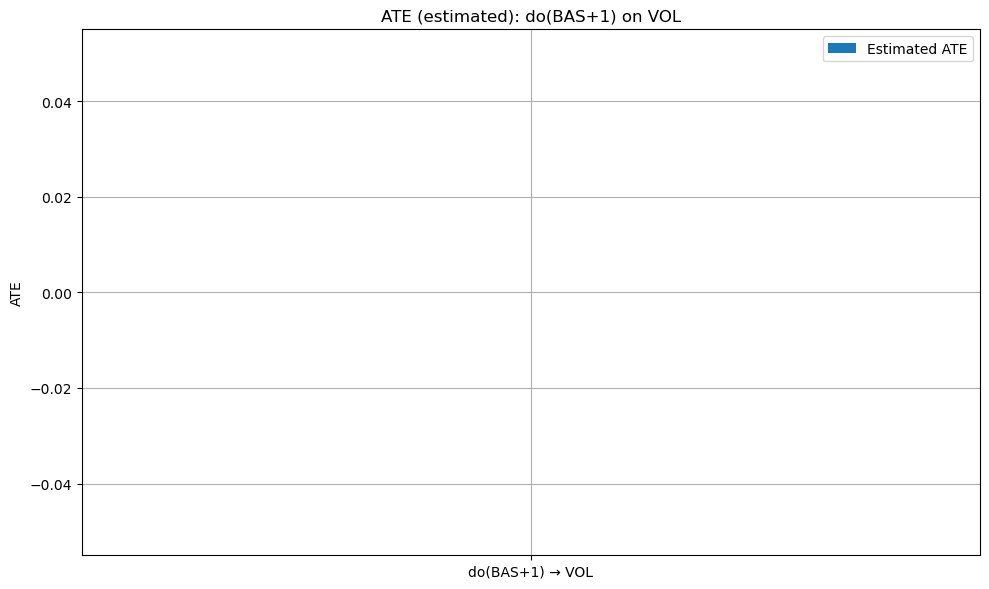

In [11]:
@torch.no_grad()
def ate_estimated(model, g, target_idx, intervene_idx, delta=1.0):
    model.eval()
    g = g.to(next(model.parameters()).device)
    p0 = model(g.x, g.edge_index)
    if hasattr(model, "do_intervention"):
        p1 = model.do_intervention(
            g.x, g.edge_index,
            intervened_nodes=torch.tensor([intervene_idx], dtype=torch.long, device=g.x.device),
            new_feature_values=(g.x[intervene_idx] + delta).unsqueeze(0)
        )
    else:
        x1 = g.x.clone(); x1[intervene_idx] += delta
        p1 = model(x1, g.edge_index)
    return (p1 - p0)[target_idx].item()

# pick a representative validation graph
g_rep = ds[idx_val[0]]
intervene_node = "BAS" if "BAS" in ds.node_map else list(ds.node_map.keys())[0]
intervene_idx = ds.node_map[intervene_node]

ate_val = ate_estimated(model, g_rep, target_idx=vol_idx, intervene_idx=intervene_idx, delta=1.0)
df_ate = pd.DataFrame([{"Estimated ATE": ate_val}], index=[f"do({intervene_node}+1) → VOL"])
display(df_ate)

ax = df_ate.plot(kind="bar", rot=0, title=f"ATE (estimated): do({intervene_node}+1) on VOL")
ax.set_ylabel("ATE"); plt.tight_layout(); plt.show()


### Case Study: Localized do() and Downstream Effects

We intervene on a node (e.g., BAS) at a representative date and show which nodes are most affected, and the effect on VOL (and optionally LIQ if present).

Top-10 affected nodes under do(BAS+1):


,Δ prediction
BAS,2.427446e+13
LIQ,5.509768e+08
PC,4.194304e+08
OI,2.135654e+07
Mom,1.493894e+04
HML,3.260312e+03
VOL,0.000000e+00


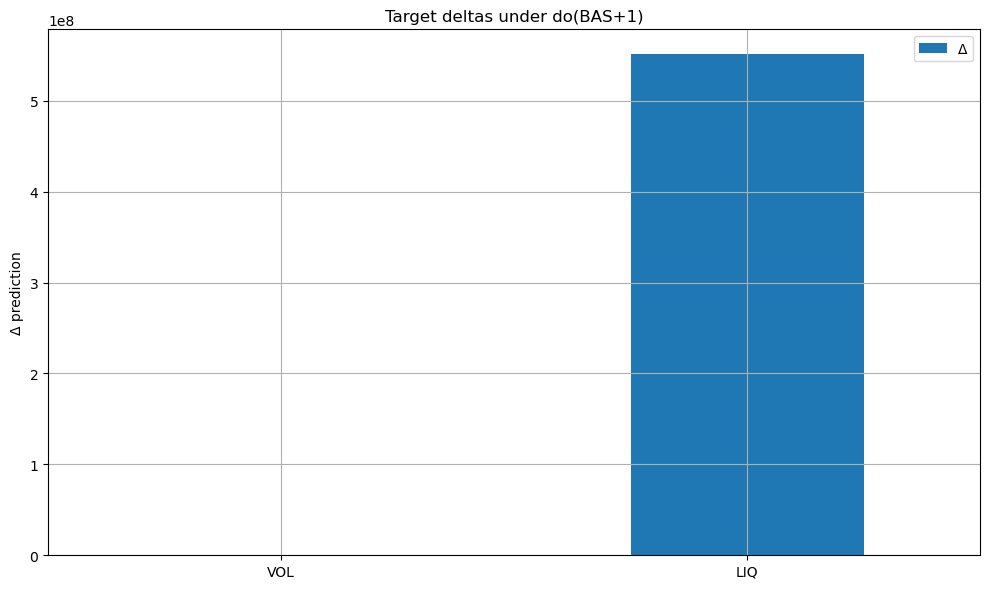

In [12]:
@torch.no_grad()
def case_study_do(model, g, node_idx, delta=1.0, topk=10):
    model.eval()
    g = g.to(next(model.parameters()).device)
    p0 = model(g.x, g.edge_index)
    if hasattr(model, "do_intervention"):
        p1 = model.do_intervention(
            g.x, g.edge_index,
            intervened_nodes=torch.tensor([node_idx], dtype=torch.long, device=g.x.device),
            new_feature_values=(g.x[node_idx] + delta).unsqueeze(0)
        )
    else:
        x1 = g.x.clone(); x1[node_idx] += delta
        p1 = model(x1, g.edge_index)
    d = (p1 - p0).squeeze(-1).detach().cpu().numpy()
    names = list(ds.node_map.keys())
    s = pd.Series(d, index=names).reindex(sorted(names))
    return s.abs().sort_values(ascending=False).head(topk), s

topk_series, raw_delta = case_study_do(model, g_rep, intervene_idx, delta=1.0, topk=10)
print(f"Top-10 affected nodes under do({intervene_node}+1):")
display(topk_series.to_frame("Δ prediction"))

# plot Δ on VOL (and LIQ if present)
to_plot = {}
to_plot["VOL"] = raw_delta["VOL"] if "VOL" in raw_delta.index else 0.0
if "LIQ" in raw_delta.index:
    to_plot["LIQ"] = raw_delta["LIQ"]

if len(to_plot) > 0:
    df_targets = pd.DataFrame(to_plot, index=["Δ"]).T
    ax = df_targets.plot(kind="bar", rot=0, title=f"Target deltas under do({intervene_node}+1)")
    ax.set_ylabel("Δ prediction"); plt.tight_layout(); plt.show()
